# Using the Model Files

This notebook demonstrates use of the .fits files containing the wavelength-dependent extinction, emission, and polarization of the astrodust+PAH model assuming a fiducial size distribution. The data files needed to run this notebook are available here:  https://doi.org/10.7910/DVN/3B6E6S.

Please cite Hensley & Draine 2022 if using these data and/or code.

In [1]:
import numpy as np
from astropy.io import fits
from scipy import interpolate

import matplotlib
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt

Read in the file and get the data from each HDU.

In [2]:
hdul = fits.open('astrodust+PAH_MW_RV3.1.fits')
hdul.info()
size_dist = hdul[1].data
ext = hdul[2].data
scatt = hdul[3].data
extpol = hdul[4].data
logU = hdul[5].data
wav = hdul[6].data
emiss = hdul[7].data
emisspol = hdul[8].data
spdust = hdul[9].data

Filename: astrodust+PAH_MW_RV3.1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  SIZE DISTRIBUTION    1 ImageHDU        17   (5, 167)   float64   
  2  EXTINCTION    1 ImageHDU        14   (4, 1000)   float64   
  3  SCATTERING    1 ImageHDU        14   (4, 1000)   float64   
  4  POLARIZED EXTINCTION    1 ImageHDU        12   (2, 1000)   float64   
  5  LOG10 U       1 ImageHDU         9   (91,)   float64   
  6  WAVELENGTHS    1 ImageHDU         9   (1000,)   float64   
  7  EMISSION      1 ImageHDU        14   (3, 1000, 91)   float64   
  8  POLARIZED EMISSION    1 ImageHDU        12   (1000, 91)   float64   
  9  SPINNING DUST EMISSION    1 ImageHDU        18   (6, 1000)   float64   


## The Size Distribution

The size distribution HDU contains the effective radii in the first colum, $dn_{\rm Ad}/n_{\rm H}$ in the second column, $dn_{\rm PAH}/n_{\rm H}$ in the third column, $f_{\rm ion}$ in the fourth column, and $f_{\rm align}$ in the fifth column.

Note that the $dn$ values already include integration over the size bin. This makes it convenient for use with cross section files to compute observables but at the expense of being dependent on the provided binning. The provided bins are log-spaced with $d\ln a = 0.0576$.

For visualization purposes, we plot: $(4\pi/3)a^3\ \left({\rm dn/d\,ln\,a}\right)/n_{\rm H}$, requiring that we multiply the provided $dn/n_{\rm H}$ by $(4\pi/3)a^3/d\ln a$.

In [3]:
rad = size_dist[:,0]
dlna = np.log(rad[20]/rad[0])/20.

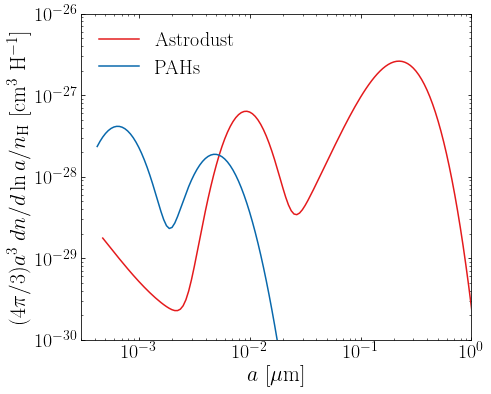

In [4]:
fig, ax = plt.subplots(1,1,figsize=(7., 6.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$a\ [\mu{\rm m}]$',fontsize=22)
ax.set_ylabel(r'$(4\pi/3)a^3\ dn/d\ln a/n_{\rm H}\ [{\rm cm}^3\ \rm{H}^{-1}]$',fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')
ax.axis([3.e-4, 1., 1.e-30, 1.e-26])

idx = np.where(size_dist[:,1] > 0.)
ax.plot(rad[idx],size_dist[:,1][idx]*np.pi*(4./3.)*(rad[idx]*1.e-4)**3/dlna,color='#e41a1c',
           linestyle='-', label=r'${\rm Astrodust}$')
idx = np.where(size_dist[:,2] > 0.)
ax.plot(rad[idx],size_dist[:,2][idx]*np.pi*(4./3.)*(rad[idx]*1.e-4)**3/dlna,color='#0868ac',
           linestyle='-', label=r'${\rm PAHs}$')
ax.legend(loc='upper left', frameon=False, prop={'size': 20});

We can also compute the total grain volume and mass, both per H atom.

In [5]:
V_Ad = (4.*np.pi/3.)*np.sum((rad*1.e-4)**3*size_dist[:,1]) # cm^3
V_PAH = (4.*np.pi/3.)*np.sum((rad*1.e-4)**3*size_dist[:,2]) # cm^3

rho_Ad = 2.74 # g/cm^3, assumes porosity 0.2
rho_PAH = 2.0 # g/cm^3

M_Ad = rho_Ad*V_Ad
M_PAH = rho_PAH*V_PAH

mp = 1.6726218e-24 # Proton mass, g
Md_MH = (M_Ad + M_PAH)/mp

print(('V_Ad: %1.2e\n')%(V_Ad) +
      ('V_PAH: %1.2e\n')%(V_PAH) +
     ('Md/MH: %.4f\n')%(Md_MH))

V_Ad: 3.92e-27
V_PAH: 5.51e-28
Md/MH: 0.0071



Also provided in this HDU are the $f_{\rm ion}$ and $f_{\rm align}$ functions.

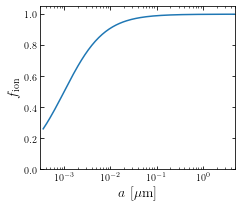

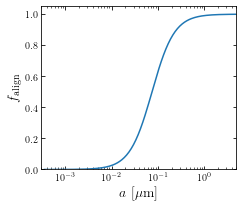

In [6]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$a\ [\mu{\rm m}]$',fontsize=14)
ax.set_ylabel(r'$f_{\rm ion}$',fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=10,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')
ax.axis([3.e-4, 5., 0., 1.05])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.plot(rad, size_dist[:,3]);

fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$a\ [\mu{\rm m}]$',fontsize=14)
ax.set_ylabel(r'$f_{\rm align}$',fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=10,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')
ax.axis([3.e-4, 5., 0., 1.05])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.plot(rad, size_dist[:,4]);

## Extinction, Polarized Extinction, and Scattering

The extinction, scattering, and polarized extinction data are simpler because they do not include a dependence on the radiation field heating the dust. The relevant HDUs therefore give these quantities simply as a function of wavelength, with the columns corresponding to the wavelength grid (0), astrodust only (1), PAH only (2), and total (3). All extinction and scattering quantities are provided in units of cm$^2$/H.

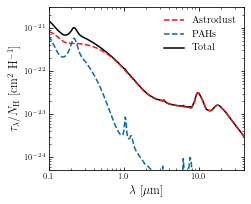

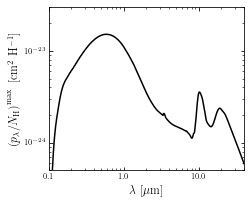

In [7]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$', fontsize=12)
ax.set_ylabel(r'$\tau_\lambda/N_{\rm H}\ [{\rm cm}^{2}\ {\rm H}^{-1}]$',
                 fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axis([0.1, 40.,  5.e-25, 3.e-21])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(ext[:,0], ext[:,1], linestyle='--', color='#e41a1c', label=r'${\rm Astrodust}$')
ax.plot(ext[:,0], ext[:,2], linestyle='--', color='#0868ac', label=r'${\rm PAHs}$')
ax.plot(ext[:,0], ext[:,3], linestyle='-', color='k', label=r'${\rm Total}$', zorder=0)
ax.legend(loc='upper right', frameon=False, prop={'size': 10});

fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$', fontsize=12)
ax.set_ylabel(r'$\left(p_\lambda/N_{\rm H}\right)^{\rm max}\ [{\rm cm}^{2}\ {\rm H}^{-1}]$',
                 fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axis([0.1, 40.,  5.e-25, 3.e-23])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(extpol[:,0], extpol[:,1], linestyle='-', color='k');

The wavelength grid is the same for all quantities, so it is straightforward to compute quantities like the albedo.

In [8]:
albedo_Ad = scatt[:,1]/ext[:,1]
albedo_PAH = scatt[:,2]/ext[:,2]
albedo_total = scatt[:,3]/ext[:,3]

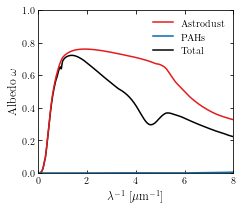

In [9]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$\lambda^{-1}\ [\mu{\rm m}^{-1}]$',fontsize=12)
ax.set_ylabel(r'${\rm Albedo}\ \omega$',fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.axis([0., 8.,  0., 1.])
ax.tick_params(axis='both', which='both', labelsize=10,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(1./ext[:,0], albedo_Ad, linestyle='-', color='#e41a1c', label=r'${\rm Astrodust}$')
ax.plot(1./ext[:,0], albedo_PAH, linestyle='-', color='#0868ac', label=r'${\rm PAHs}$')
ax.plot(1./ext[:,0], albedo_total, linestyle='-', color='k', label=r'${\rm Total}$', zorder=0)
ax.legend(loc='upper right', frameon=False, prop={'size': 10});

Note that at these wavelengths there is negligible scattering from PAHs.

## Emission and Polarized Emission

The emission from interstellar dust depends on the strength of the radiation heating it. Therefore, provided are not just the fiducial radiation field strength adopted in Hensley & Draine 2022 (log10 U = 0.2), but rather a range of log10 U values from -3 to +6. All emission quantities are provided as $\lambda I_\lambda / N_{\rm H} \equiv \nu I_\nu /N_{\rm H}$ in units of erg/s/sr/H.

The data are organized as a matrix where each entry corresponds to a wavelength and a log10 U value. As a first illustration, here are the emission and polarized emission for log10 U = 0.2. As with the extinction files, the outputs are organized in order of astrodust only (0), then PAHs only (1), then total (2).

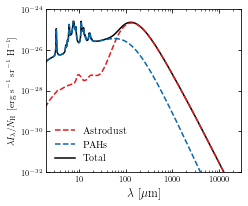

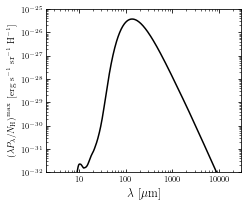

In [10]:
u_idx = np.argmin(np.abs(logU - 0.2)) # We could use interpolation here, 
                                      # but 0.2 is a provided value
    
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$', fontsize=12)
ax.set_ylabel(r'$\lambda I_\lambda/N_{\rm H}\ [{\rm erg}\ {\rm s}^{-1}\ {\rm sr}^{-1}\ {\rm H}^{-1}]$',
                 fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axis([2., 3.e4,  1.e-32, 1.e-24])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(wav, emiss[u_idx,:,0], linestyle='--', color='#e41a1c', label=r'${\rm Astrodust}$')
ax.plot(wav, emiss[u_idx,:,1], linestyle='--', color='#0868ac', label=r'${\rm PAHs}$')
ax.plot(wav, emiss[u_idx,:,2], linestyle='-', color='k', label=r'${\rm Total}$', zorder=0)

ax.legend(loc='lower left', frameon=False, prop={'size': 10});

fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$', fontsize=12)
ax.set_ylabel(r'$\left(\lambda P_\lambda/N_{\rm H}\right)^{\rm max}\ [{\rm erg}\ {\rm s}^{-1}\ {\rm sr}^{-1}\ {\rm H}^{-1}]$',
                 fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axis([2., 3.e4,  1.e-32, 1.e-25])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(wav, emisspol[u_idx,:], linestyle='-', color='k');

With the full grid of U values, we can do an interpolation to produce spectra at any U. Compare the plot below to Draine & Li 2007, Figure 13.

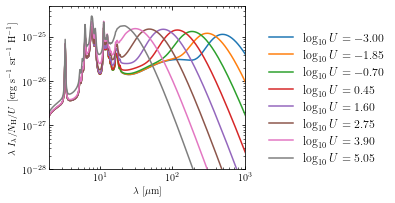

In [13]:
emiss_spl = interpolate.RectBivariateSpline(logU, wav, emiss[:,:,2])

fig, ax = plt.subplots(1,1,figsize=(3.5, 3),sharex=True)
fig.subplots_adjust(hspace=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$',fontsize=10)
ax.set_ylabel(r'$\lambda\ I_\lambda/N_{\rm H}/U\ [{\rm erg}\ {\rm s}^{-1}\ {\rm sr}^{-1}\ {\rm H}^{-1}]$',fontsize=10)
ax.tick_params(axis='both', which='both', labelsize=10,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')
ax.axis([2., 1000., 1.e-28, 5.e-25])

for u_out in np.arange(-3.,6.,1.15):
    irem_out = emiss_spl.ev(u_out, wav)
    ax.plot(wav, irem_out/10**u_out, label = (r'$\log_{10} U = %1.2f$') % u_out)
ax.legend(loc=(1.1,0), frameon=False, prop={'size': 12});

When using the model to do SED fitting, it may be more convenient to normalize the emission by the dust mass surface density $\Sigma_d$ instead of $N_{\rm H}$:

$\Sigma_d = m_p N_{\rm H} \left(\frac{M_d}{M_{\rm H}}\right) = 0.0071 \Sigma_{\rm H} = 1.18\times10^{-26}\,{\rm g}\,N_{\rm H}$

for our standard local MW dust to gas mass ratio. Note that equivalent factors can be derived for the astrodust and PAH components individually if they are being fit separately.

## Spinning Dust Emission

The model file provides spinning dust spectra for astrodust and PAHs in the CNM and WNM computed with SpDust using the fiducial ISM and grain properties described in Hensley & Draine 2022. These can be added to the emission spectra if desired, but note that these are not provided as a function of radiation field intensity. In practice, over a wide range of U values, the spinning dust spectrum is fairly constant. $f_{\rm CNM} = 1 - f_{\rm WNM} = 0.28$ is assumed.

Note the conversion from $\lambda I_\lambda/N_{\rm H}$ in erg/s/sr/H to $I_\nu/N_{\rm H}$ in Jy cm$^{2}$/sr/H. The ordering is wavelengths (0), astrodust CNM (1), astrodust WNM (2), PAH CNM (3), PAH WNM (4), and total (5).

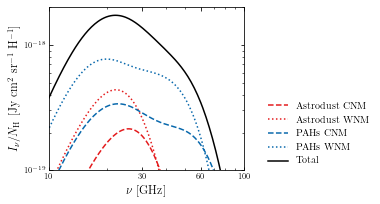

In [12]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\nu\ [{\rm GHz}]$', fontsize=12)
ax.set_ylabel(r'$I_\nu/N_{\rm H}\ [{\rm Jy}\ {\rm cm}^{2}\ {\rm sr}^{-1}\ {\rm H}^{-1}]$',
              fontsize=12)
ax.axis([10., 100., 1.e-19, 2.e-18])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([10, 30, 60, 100])

c = 2.99792458e10 # Speed of light, cm/s
nu = c/(1.e-4*spdust[:,0])

ax.plot(nu*1.e-9, 1.e23*spdust[:,1]/nu, linestyle='--', color='#e41a1c', label=r'${\rm Astrodust\ CNM}$')
ax.plot(nu*1.e-9, 1.e23*spdust[:,2]/nu, linestyle=':', color='#e41a1c', label=r'${\rm Astrodust\ WNM}$')
ax.plot(nu*1.e-9, 1.e23*spdust[:,3]/nu, linestyle='--', color='#0868ac', label=r'${\rm PAHs\ CNM}$')
ax.plot(nu*1.e-9, 1.e23*spdust[:,4]/nu, linestyle=':', color='#0868ac', label=r'${\rm PAHs\ WNM}$')
ax.plot(nu*1.e-9, 1.e23*spdust[:,5]/nu, linestyle='-', color='k', label=r'${\rm Total}$', zorder=0)

ax.legend(loc=(1.1,0), frameon=False, prop={'size': 10});